In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/AmesHousing.csv')

In [3]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


**Removing Columns With Excessive Null Values**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [5]:
for i in df.columns:
  if df[i].isna().sum() > 1000:
    df.drop(i, axis = 1,  inplace = True)
  elif df[i].isna().sum() > 0 and df[i].isna().sum() < 1000 and df[i].dtype == 'O':
    df[i].fillna(df[i].mode()[0], inplace = True)
  else:
    if df[i].isna().sum() > 0 and df[i].isna().sum() < 1000 and (df[i].dtype == 'float64' or df[i].dtype == 'int64'):
      df[i].fillna(df[i].mean(), inplace = True)

<Axes: xlabel='SalePrice', ylabel='Count'>

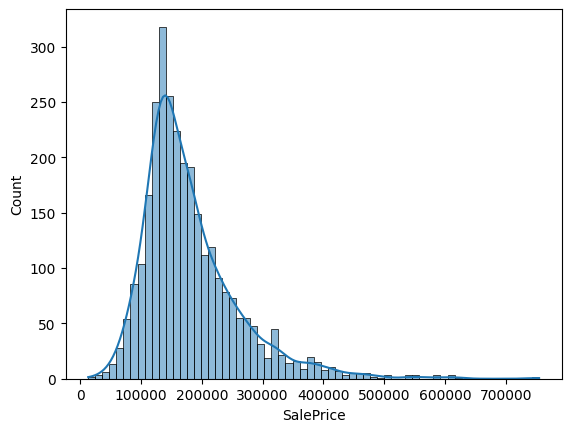

In [6]:
sns.histplot(x = df['SalePrice'], kde = True)

**Feature Selection**

In [7]:
final_df = pd.get_dummies(df, drop_first=True)

In [8]:
X = final_df.drop('SalePrice', axis = 1)
y = final_df['SalePrice']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
#We'll Use XGB Regressor To Find Most Influential Features to Reduce Dimensionality

from xgboost import XGBRegressor

model = XGBRegressor()

model.fit(X_train, y_train)

importance = model.get_booster().get_score(importance_type='gain')

In [11]:
importance_df = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance':importance.values()
})

In [12]:
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)

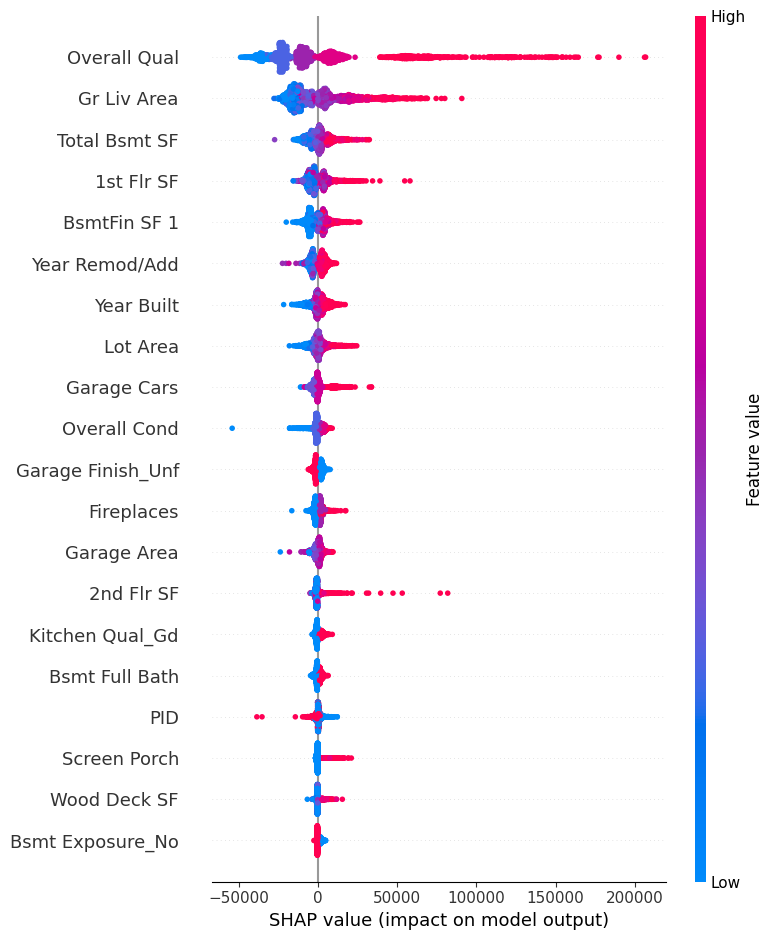

In [14]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

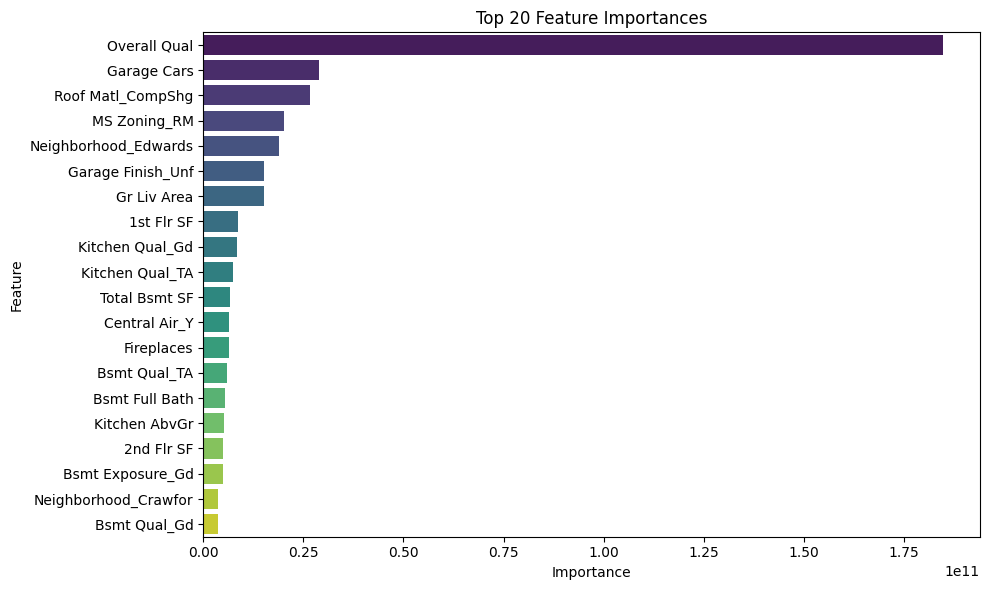

In [15]:
#Let's Use Only Top 20 Features

column = importance_df.head(20)['Feature'].tolist()

top_features = importance_df.head(20)  # only top 20
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [16]:
model_df = final_df[column]

model_df = model_df.apply(pd.to_numeric, errors = 'coerce')
X_model = model_df
y_model = df['SalePrice']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X_model = scaler.fit_transform(X_model)

# **1.Linear Regression Model**

In [17]:
#Let's make a scaled version of model_df

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
#We are Using The Scaled Version Here
X_train, X_test, y_train, y_test = train_test_split(scaled_X_model, y_model, test_size=0.20, random_state=42)

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)


LinearRegression()

In [22]:
linear_predict_test = model_linear.predict(X_test)
linear_predict_train = model_linear.predict(X_train)

**UnderFitting / Overfitting (Linear Regression)**

In [23]:
linear_train_score = r2_score(y_train, linear_predict_train)
linear_test_score = r2_score(y_test, linear_predict_test)


linear_mse_train = mean_squared_error(y_train, linear_predict_train)
linear_mse_test = mean_squared_error(y_test, linear_predict_test)


linear_scores = pd.DataFrame({
    'Linear Train Score R2':[linear_train_score],
    'Linear Test Score R2':[linear_test_score],
    'Linear Train Score MSE':[linear_mse_train],
    'Linear Test Score MSE':[linear_mse_test]

})

linear_scores

,Linear Train Score R2,Linear Test Score R2,Linear Train Score MSE,Linear Test Score MSE
0,0.831915,0.85374,9.993873e+08,1.172650e+09


# **2.**Decision** Tree Model**

In [24]:
#We are Not Using Scaled Version of 'X' Because It's not Necessary in Decision Trees
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.20, random_state=42)

from sklearn.tree import DecisionTreeRegressor

model_DT = DecisionTreeRegressor()

model_DT.fit(X_train, y_train)

DT_predict_test = model_DT.predict(X_test)
DT_predict_train = model_DT.predict(X_train)

**UnderFitting / OverFitting (Decision Tree Regressor)**

In [25]:
DT_train_score = r2_score(y_train, DT_predict_train)
DT_test_score = r2_score(y_test, DT_predict_test)

DT_mse_train = mean_squared_error(y_train, DT_predict_train)
DT_mse_test = mean_squared_error(y_test, DT_predict_test)


DT_scores = pd.DataFrame({
    'DT Train Score R2':[DT_train_score],
    'DT Test Score R2':[DT_test_score],

    'DT Train Score MSE':[DT_mse_train],
    'DT Test Score MSE':[DT_mse_test],

})

DT_scores

,DT Train Score R2,DT Test Score R2,DT Train Score MSE,DT Test Score MSE
0,0.999456,0.861517,3.232497e+06,1.110293e+09


**So Here Our Model Is Overfitting Because The Train Score is High and Test Score is Much Lower, Because of The Reason We'll Be Using Random Forest**

In [26]:
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=10,
    random_state=42
)

rfr_model.fit(X_train, y_train)

rfr_predict_test = rfr_model.predict(X_test)
rfr_predict_train = rfr_model.predict(X_train)

In [27]:
rfr_train_score = r2_score(y_train, rfr_predict_train)
rfr_test_score = r2_score(y_test, rfr_predict_test)

rfr_train_mse = mean_squared_error(y_train, rfr_predict_train)
rfr_test_mse = mean_squared_error(y_test, rfr_predict_test)

rfr_scores = pd.DataFrame({
    'RFR Train Score R2':[rfr_train_score],
    'RFR Test Score R2':[rfr_test_score],

    'RFR Train MSE':[rfr_train_mse],
    'RFR Test MSE':[rfr_test_mse]
})

rfr_scores

,RFR Train Score R2,RFR Test Score R2,RFR Train MSE,RFR Test MSE
0,0.959906,0.902215,2.383892e+08,7.839922e+08


**Now Let's Do Hyper-Parameter Tuning For Random Forest Regressor**

In [28]:
from sklearn.model_selection import RandomizedSearchCV

baseline = RandomizedSearchCV(rfr_model, {
    'n_estimators':[50,100,150,200],
    'max_depth':[5,10,15,20,25,30,None],
    'min_samples_split':[5,10,15,20],
}, n_iter = 15, cv = 5, return_train_score = False)

In [29]:
baseline.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(min_samples_split=10,
                                                   random_state=42),
                   n_iter=15,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30,
                                                      None],
                                        'min_samples_split': [5, 10, 15, 20],
                                        'n_estimators': [50, 100, 150, 200]})

In [30]:
baseline.best_params_

{'n_estimators': 150, 'min_samples_split': 10, 'max_depth': None}

In [31]:
baseline.best_score_

np.float64(0.8817817997341919)

In [32]:
baseline.best_estimator_

RandomForestRegressor(min_samples_split=10, n_estimators=150, random_state=42)

In [33]:
baseline_predict_test = baseline.predict(X_test)
baseline_predict_train = baseline.predict(X_train)

baseline_test_r2 = r2_score(y_test,baseline_predict_test)
baseline_test_mse = mean_squared_error(y_test, baseline_predict_test)

baseline_train_r2 = r2_score(y_train, baseline_predict_train)
baseline_train_mse = mean_squared_error(y_train, baseline_predict_train)

baseline_scores = pd.DataFrame({
    'Baseline Train R2':[baseline_train_r2],
    'Baseline Test R2':[baseline_test_r2],

    'Baseline Train MSE':[baseline_train_mse],
    'Baseline Test MSE':[baseline_test_mse]
})

In [34]:
baseline_scores

,Baseline Train R2,Baseline Test R2,Baseline Train MSE,Baseline Test MSE
0,0.959715,0.901705,2.395217e+08,7.880886e+08


In [35]:
labels = ['LR Train', 'LR Test', 'RF Train', 'RF Test', 'DT Train', 'DT Test']
scores_df = pd.DataFrame({
    'R2 SCORE':[linear_train_score, linear_test_score, rfr_train_score, rfr_test_score, DT_train_score, DT_test_score],
    'MSE SCORE':[linear_mse_train, linear_mse_test, rfr_train_mse, rfr_test_mse, DT_mse_train, DT_mse_test],
}, index = labels).round(3)

In [36]:
scores_df

,R2 SCORE,MSE SCORE
LR Train,0.832,9.993873e+08
LR Test,0.854,1.172650e+09
RF Train,0.960,2.383892e+08
RF Test,0.902,7.839922e+08
DT Train,0.999,3.232497e+06
DT Test,0.862,1.110293e+09


**Linear Regression Scatter Plot (Actual vs Predicted)**

Text(0.5, 1.0, 'Actual vs Predicted Sales Price (Linear Regression)')

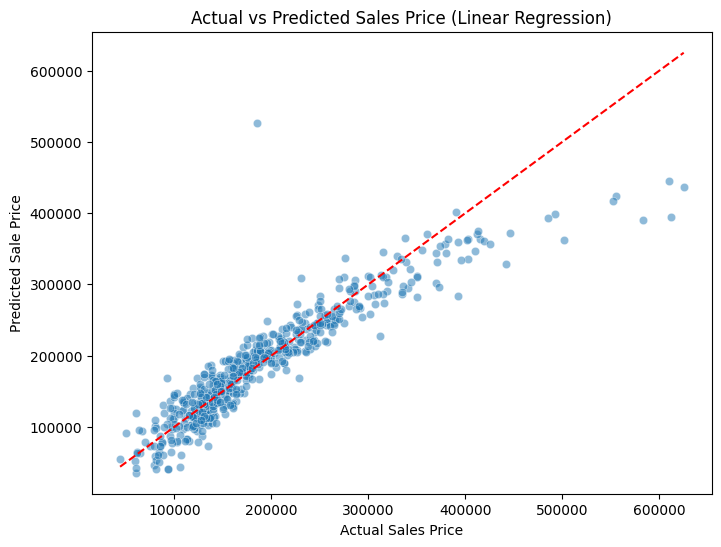

In [37]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test, y = linear_predict_test, alpha = 0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sales Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sales Price (Linear Regression)')

**Decision Tree Scatter Plot (Actual vs Predicted)**

Text(0.5, 1.0, 'Actual vs Predicted Sales Price (Decision Tree)')

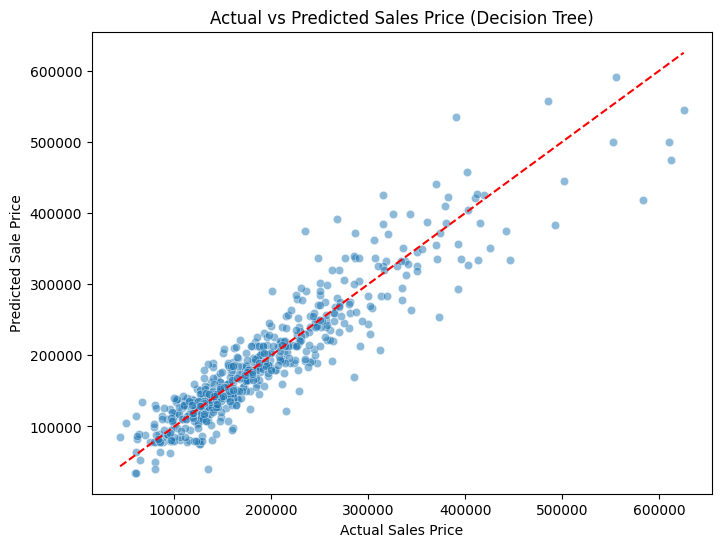

In [38]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test, y = DT_predict_test, alpha = 0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sales Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sales Price (Decision Tree)')

**Random Forest Scatter Plot (Actual vs Predicted)**

Text(0.5, 1.0, 'Actual vs Predicted Sales Price (Random Forest)')

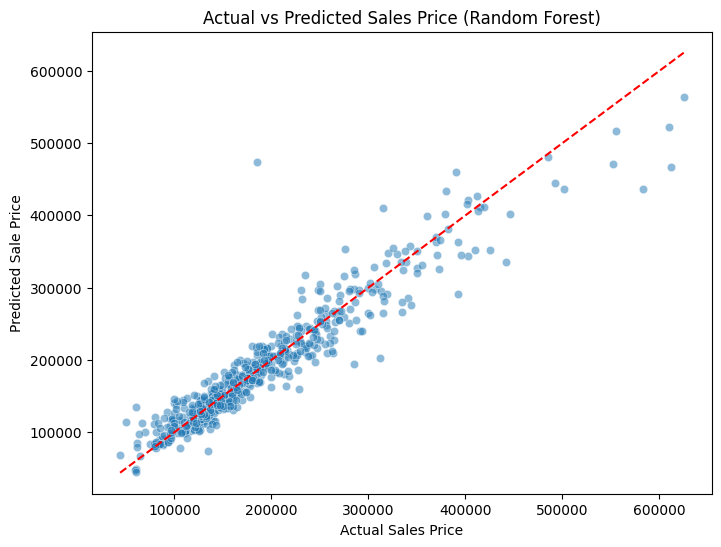

In [39]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = y_test, y = rfr_predict_test, alpha = 0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sales Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sales Price (Random Forest)')

# **Summary**

* We Got A Messy Dataset With Lot's Of Missing Data To Predict The Sales Price of Houses.

* We Cleaned The Dataset And Use One-Hot-Encoding To Convert Categorical Features To 0 and 1.

* Then We Used XGBOOST REGRESSOR To Find The Most Influential and Highly Co-Related Features, After That We Picked Top 20 Features and Make Some Models On It.

* Since Our Output Feature Was Continuous, We Trained Our DataSet on Linear Regression at First.

* On Linear Regression We Got Train Score of 83% and Test Score of 85%.

* Then We Decided To Try Some Other Models Also, So We Decided To Use Decision Tree Regressor.

* On Decision Tree Regressor We Got Train Score of 99% and Test Score Of 84%, So Here Our Model Was Overfit.

* To Get Rid of This Overfitting We Used Random Forest Regressor and Trained The Dataset Again.

* We Decided To use HyperParameter Tuning For Random Forest and Then We Used Random Search CV.

* After Getting The Best Parameters For Random Forest Through HyperParameter Tuning We Got Train Score of 96% and Test Score of 90.2%.

Note: All Three Models Perfrom Well in The Majority Range But struggles with High-Value Houses Due To Data Sparsity and Complexity. Ensemble Methods Like XGBOOST/Random Forest Reduce This But Don't Fully Eliminate It.

